In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import sys, os

# Get absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

sys.path.append("/cluster/home/herminea/mental_health_project/workspace/utils")
sys.path.append("/cluster/home/herminea/mental_health_project/workspace/scripts")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from utils.io_results import load_results, group_results_by_subject

# --- Load combined FCs ---
RES_MVMD = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/combined_fc"
RES_VLMD = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/vlmd/combined_fc"

In [3]:

def load_fc_data(res_dir):
    results = load_results(res_dir)
    subjects_combined = group_results_by_subject(results)

    fcs_by_imf = defaultdict(dict)
    groups = {}
    freqs_by_imf = defaultdict(list)

    for subj, entries in subjects_combined.items():
        entry = entries[0]
        groups[subj] = entry["group"]
        fcs_by_imf["whole"][subj] = entry["fc_whole"]
        for i, fc in enumerate(entry["fc_modes"], start=1):
            fcs_by_imf[i][subj] = fc
            freqs_by_imf[i].append(entry["freqs"][i-1])

    return subjects_combined, fcs_by_imf, groups, freqs_by_imf

def flatten_fc(fc):
    iu = np.triu_indices(fc.shape[0], 1)
    return fc[iu]

def compute_similarity_matrix(fcs):
    subs = list(fcs.keys())
    X = np.array([flatten_fc(fcs[s]) for s in subs])
    sim = 1 - squareform(pdist(X, metric='correlation'))
    return sim, subs

def group_similarity_means(sim, subs, groups):
    mdd_idx = [i for i, s in enumerate(subs) if groups[s] == "MDD"]
    hc_idx  = [i for i, s in enumerate(subs) if groups[s] == "HC"]

    MDD_MDD = np.nanmean(sim[np.ix_(mdd_idx, mdd_idx)][~np.eye(len(mdd_idx), dtype=bool)])
    HC_HC   = np.nanmean(sim[np.ix_(hc_idx, hc_idx)][~np.eye(len(hc_idx), dtype=bool)])
    MDD_HC  = np.nanmean(sim[np.ix_(mdd_idx, hc_idx)])
    return MDD_MDD, HC_HC, MDD_HC

def hedges_g(x1, x2):
    """Compute Hedges' g (bias-corrected Cohen's d) for two independent samples."""
    x1, x2 = np.asarray(x1), np.asarray(x2)
    x1, x2 = x1[~np.isnan(x1)], x2[~np.isnan(x2)]
    if len(x1) < 2 or len(x2) < 2:
        return np.nan
    
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.nanstd(x1, ddof=1), np.nanstd(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
    d = (np.nanmean(x1) - np.nanmean(x2)) / s_pooled

    # Correction for small sample bias
    correction = 1 - (3 / (4*(n1 + n2) - 9))
    g = d * correction
    return g


def cohen_d(x1, x2):
    """Compute Cohen's d for two independent samples (handles NaNs)."""
    x1, x2 = np.asarray(x1), np.asarray(x2)
    x1, x2 = x1[~np.isnan(x1)], x2[~np.isnan(x2)]
    if len(x1) < 2 or len(x2) < 2:
        return np.nan
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.nanstd(x1, ddof=1), np.nanstd(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
    return (np.nanmean(x1) - np.nanmean(x2)) / s_pooled


def permutation_test_within_vs_between(sim, subs, groups, n_perm=5000, seed=42):
    rng = np.random.default_rng(seed)
    mdd_idx = [i for i, s in enumerate(subs) if groups[s] == "MDD"]
    hc_idx  = [i for i, s in enumerate(subs) if groups[s] == "HC"]

    within = np.concatenate([
        sim[np.ix_(mdd_idx, mdd_idx)][~np.eye(len(mdd_idx), dtype=bool)],
        sim[np.ix_(hc_idx, hc_idx)][~np.eye(len(hc_idx), dtype=bool)]
    ])
    between = sim[np.ix_(mdd_idx, hc_idx)].ravel()
    true_diff = np.mean(within) - np.mean(between)

    all_idx = np.arange(len(subs))
    n_mdd = len(mdd_idx)
    perm_diffs = np.empty(n_perm)
    for k in range(n_perm):
        rng.shuffle(all_idx)
        MDD_p, HC_p = all_idx[:n_mdd], all_idx[n_mdd:]
        within_p = np.concatenate([
            sim[np.ix_(MDD_p, MDD_p)][~np.eye(len(MDD_p), dtype=bool)],
            sim[np.ix_(HC_p, HC_p)][~np.eye(len(HC_p), dtype=bool)]
        ])
        between_p = sim[np.ix_(MDD_p, HC_p)].ravel()
        perm_diffs[k] = np.mean(within_p) - np.mean(between_p)

    pval = np.mean(np.abs(perm_diffs) >= np.abs(true_diff))
    return true_diff, pval

def analyze_similarity_by_imf(fcs_by_imf, groups):
    results = []
    for imf_idx, fcs in fcs_by_imf.items():
        sim, subs = compute_similarity_matrix(fcs)
        MDD_MDD, HC_HC, MDD_HC = group_similarity_means(sim, subs, groups)
        diff, pval = permutation_test_within_vs_between(sim, subs, groups)
        results.append((imf_idx, MDD_MDD, HC_HC, MDD_HC, diff, pval))
    return pd.DataFrame(results, columns=["IMF", "MDD–MDD", "HC–HC", "MDD–HC", "Δ", "p"])
def fc_similarity(fc1, fc2):
    v1, v2 = flatten_fc(fc1), flatten_fc(fc2)
    return 1 - pdist(np.vstack([v1, v2]), metric='correlation')[0]

In [4]:
subs_mvmd, fcs_by_imf_mvmd, groups, freqs_by_imf_mvmd = load_fc_data(RES_MVMD)
subs_vlmd, fcs_by_imf_vlmd, groups_v, freqs_by_imf_vlmd = load_fc_data(RES_VLMD)

# Ensure group dict is consistent and take common subjects
assert groups == groups_v or True  # just to remind; we’ll use groups from MVMD load
common_subs = sorted(set(groups) & set(subs_mvmd.keys()) & set(subs_vlmd.keys()))

# Frequency bands you already defined
freq_bands = {
    "Slow-6": (0.00, 0.01),
    "Slow-5": (0.01, 0.027),
    "Slow-4": (0.027, 0.073),
    "Slow-3": (0.073, 0.198),
    "Slow-2": (0.198, 0.25),
}



[Load] Loaded 42 FC result files from /cluster/home/herminea/mental_health_project/test/results/fmri_prep/mvmd/combined_fc
[Load] Loaded 42 FC result files from /cluster/home/herminea/mental_health_project/test/results/fmri_prep/vlmd/combined_fc


In [6]:
def bin_fcs_by_freq(subjects_combined, freq_bands):
    binned = {band: defaultdict(list) for band in freq_bands}
    
    for subj, entries in subjects_combined.items():
        e = entries[0]
        # Assign each IMF FC to its corresponding frequency band
        for f, fc in zip(e["freqs"], e["fc_modes"]):
            for band, (fmin, fmax) in freq_bands.items():
                if fmin <= f < fmax:
                    binned[band][subj].append(fc)
                    


    # Average FCs per subject for each band
    binned_mean = {
        band: {s: np.nanmean(fcs, axis=0) for s, fcs in subj_dict.items()}
        for band, subj_dict in binned.items()
    }

    return binned_mean

In [12]:
# Reuse your bin_fcs_by_freq() and add Whole
fcs_by_band_mvmd = bin_fcs_by_freq(subs_mvmd, freq_bands)
fcs_by_band_vlmd = bin_fcs_by_freq(subs_vlmd, freq_bands)

# Add Whole band for both
fcs_by_band_mvmd["Whole"] = {s: fcs_by_imf_mvmd["whole"][s] for s in common_subs if s in fcs_by_imf_mvmd["whole"]}
fcs_by_band_vlmd["Whole"] = {s: fcs_by_imf_vlmd["whole"][s] for s in common_subs if s in fcs_by_imf_vlmd["whole"]}

# Ensure same band order
order = ["Whole", "Slow-6", "Slow-5", "Slow-4", "Slow-3", "Slow-2"]


In [13]:
import numpy as np
import pandas as pd
from scipy.stats import bootstrap

def subject_similarity_per_band(fcs_mvmd_band, fcs_vlmd_band, common_subs):
    rows = []
    for s in common_subs:
        if s in fcs_mvmd_band and s in fcs_vlmd_band:
            sim = fc_similarity(fcs_mvmd_band[s], fcs_vlmd_band[s])  # your helper (edgewise Pearson r)
            rows.append({"Subject": s, "Group": groups[s], "Similarity": sim})
    return pd.DataFrame(rows)

# Collect per-band results
sim_band_df = []
for band in order:
    df_band = subject_similarity_per_band(fcs_by_band_mvmd.get(band, {}), 
                                          fcs_by_band_vlmd.get(band, {}), 
                                          common_subs)
    df_band["Band"] = band
    sim_band_df.append(df_band)

sim_band_df = pd.concat(sim_band_df, ignore_index=True)

# Summaries per group/band + effect sizes and bootstrap CIs
def boot_ci(x, conf=0.95, n_resamples=5000, seed=0):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    if len(x) < 2:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    res = bootstrap((x,), np.mean, vectorized=False, confidence_level=conf, n_resamples=n_resamples, random_state=rng)
    return res.confidence_interval.low, res.confidence_interval.high

rows = []
for band in order:
    dfb = sim_band_df[sim_band_df["Band"]==band]
    mdd = dfb[dfb["Group"]=="MDD"]["Similarity"].values
    hc  = dfb[dfb["Group"]=="HC"]["Similarity"].values
    mean_m, mean_h = np.nanmean(mdd), np.nanmean(hc)
    ci_m = boot_ci(mdd); ci_h = boot_ci(hc)
    g = hedges_g(mdd, hc); d = cohen_d(mdd, hc)
    rows.append({
        "Band": band,
        "Mean_MDD": mean_m, "CI_MDD_low": ci_m[0], "CI_MDD_high": ci_m[1],
        "Mean_HC":  mean_h, "CI_HC_low":  ci_h[0], "CI_HC_high":  ci_h[1],
        "Hedges_g": g, "Cohen_d": d,
        "Δ(MDD-HC)": mean_m - mean_h
    })

sim_summary = pd.DataFrame(rows)
print(sim_summary)


/cluster/home/herminea/.conda/envs/neuro/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/cluster/home/herminea/.conda/envs/neuro/lib/python3.10/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)
/tmp/ipykernel_4086923/663049772.py:39: RuntimeWarning: Mean of empty slice
  mean_m, mean_h = np.nanmean(mdd), np.nanmean(hc)


     Band  Mean_MDD  CI_MDD_low  CI_MDD_high   Mean_HC  CI_HC_low  CI_HC_high  \
0   Whole  1.000000         NaN          NaN  1.000000        NaN         NaN   
1  Slow-6       NaN         NaN          NaN       NaN        NaN         NaN   
2  Slow-5  0.935387    0.905807     0.952602  0.936971   0.905028    0.958661   
3  Slow-4  0.889580    0.854452     0.919461  0.884508   0.827534    0.919313   
4  Slow-3  0.753448    0.702914     0.802775  0.733361   0.670893    0.793742   
5  Slow-2  0.473215    0.398211     0.548220  0.674007   0.491582    0.816561   

   Hedges_g   Cohen_d  Δ(MDD-HC)  
0  0.000000  0.000000   0.000000  
1       NaN       NaN        NaN  
2 -0.026884 -0.027429  -0.001584  
3  0.055060  0.056147   0.005072  
4  0.157090  0.160660   0.020087  
5 -1.065962 -1.199207  -0.200791  


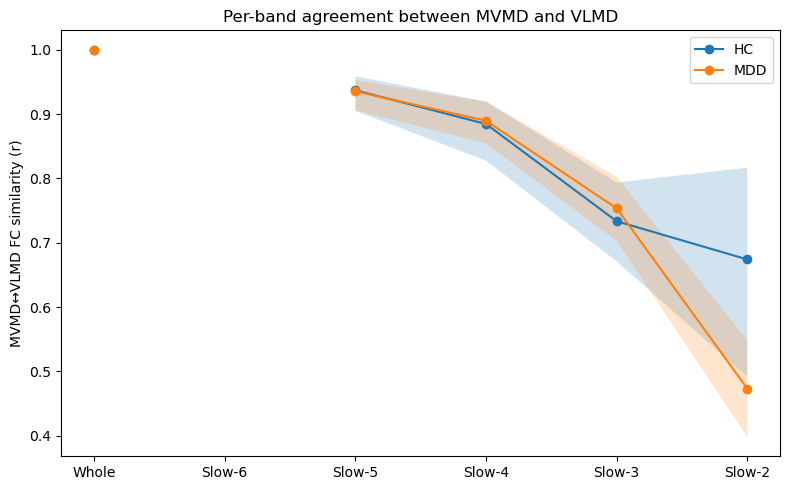

In [14]:
import matplotlib.pyplot as plt

x = np.arange(len(order))

plt.figure(figsize=(8,5))
# HC
hc_means = sim_summary["Mean_HC"].values
hc_low   = sim_summary["CI_HC_low"].values
hc_high  = sim_summary["CI_HC_high"].values
plt.plot(x, hc_means, 'o-', label='HC')
plt.fill_between(x, hc_low, hc_high, alpha=0.2)

# MDD
mdd_means = sim_summary["Mean_MDD"].values
mdd_low   = sim_summary["CI_MDD_low"].values
mdd_high  = sim_summary["CI_MDD_high"].values
plt.plot(x, mdd_means, 'o-', label='MDD')
plt.fill_between(x, mdd_low, mdd_high, alpha=0.2)

plt.xticks(x, order)
plt.ylabel("MVMD↔VLMD FC similarity (r)")
plt.title("Per-band agreement between MVMD and VLMD")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
from scipy.stats import pearsonr

def group_delta_mat(subj_fcs, groups, subs):
    mdd = np.array([subj_fcs[s] for s in subs if groups[s]=="MDD"])
    hc  = np.array([subj_fcs[s] for s in subs if groups[s]=="HC"])
    return np.nanmean(mdd, axis=0) - np.nanmean(hc, axis=0)

def uppertri(A):
    iu = np.triu_indices_from(A, 1)
    return A[iu]

delta_corr_rows = []
for band in order:
    mv = fcs_by_band_mvmd.get(band, {})
    vl = fcs_by_band_vlmd.get(band, {})
    subs = sorted(set(mv.keys()) & set(vl.keys()) & set(common_subs))
    if len(subs) < 6:  # sanity
        continue
    dA = group_delta_mat(mv, groups, subs)
    dB = group_delta_mat(vl, groups, subs)
    r, _ = pearsonr(uppertri(dA), uppertri(dB))
    delta_corr_rows.append({"Band": band, "ΔFC_pattern_corr": r})

delta_corr = pd.DataFrame(delta_corr_rows)
print(delta_corr)


     Band  ΔFC_pattern_corr
0   Whole          1.000000
1  Slow-5          0.875465
2  Slow-4          0.809417
3  Slow-3          0.680923
4  Slow-2          0.586037
